In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
data_paths = {
    "zillow": "./data/out/zillow.csv",
    "zillow+demographics": "./data/out/zillow+demographics.csv",
    "zillow_market_2018+": "./data/out/zillow_market_2018+.csv",
    "data.gov_personal_income": "./data/in/data.gov_personal_income.csv",
}

## Demographics

#### Helper functions

In [3]:
df = pd.read_csv(data_paths["data.gov_personal_income"])
df["Year"] = df["Year"].astype(int)
df["Population Count"] = df["Population Count"].apply(lambda x: x.replace(",", "")).astype(int)
df["Personal Income"] = df["Personal Income"].apply(lambda x: x.replace("$", "\\$"))
df.head()

,Year,Age,Gender,Educational Attainment,Race,Personal Income,Population Count
0,2008,00 to 17,Male,High school or equivalent,White,"\$5,000 to \$9,999",1834
1,2008,00 to 17,Male,High school or equivalent,White,"\$10,000 to \$14,999",381
2,2008,00 to 17,Male,High school or equivalent,White,"\$15,000 to \$24,999",135
3,2008,00 to 17,Male,High school or equivalent,White,"\$25,000 to \$34,999",268
4,2008,00 to 17,Male,High school or equivalent,White,"\$35,000 to \$49,999",0


In [4]:
def reorder_column(df, col, order):
    df[col] = pd.Categorical(df[col], categories=order, ordered=True)
    df = df.sort_values(by=col).reset_index(drop=True)
    return df

income_order = [
    "No Income",
    "\\$5,000 to \\$9,999",
    "\\$10,000 to \\$14,999",
    "\\$15,000 to \\$24,999",
    "\\$25,000 to \\$34,999",
    "\\$35,000 to \\$49,999",
    "\\$50,000 to \\$74,999",
    "\\$75,000 and over",
]

edu_order = [
    "No high school diploma",
    "High school or equivalent",
    "Some college, less than 4-yr degree",
    "Bachelor's degree or higher",
]

### Gender/Income/Population

In [5]:
gpc_df = (
    df[(df["Age"] != "00 to 17") & (df["Age"] != "65 to 80+")]
    .drop(columns=["Year", "Age", "Educational Attainment", "Race"])
    .groupby(["Gender", "Personal Income"])
    .sum()
    .reset_index()
    .copy()
)
gpc_df.head()

,Gender,Personal Income,Population Count
0,Female,No Income,34809558
1,Female,"\$10,000 to \$14,999",15349265
2,Female,"\$15,000 to \$24,999",22573482
3,Female,"\$25,000 to \$34,999",17085006
4,Female,"\$35,000 to \$49,999",18485961


In [6]:
gpc_df = reorder_column(gpc_df, "Personal Income", income_order)
gpc_df.head()

,Gender,Personal Income,Population Count
0,Female,No Income,34809558
1,Male,No Income,18997754
2,Female,"\$5,000 to \$9,999",14508106
3,Male,"\$5,000 to \$9,999",10522065
4,Female,"\$10,000 to \$14,999",15349265


In [7]:
gpc_male = (
    gpc_df[gpc_df["Gender"] == "Male"]
    .drop(columns=["Gender"])
    .reset_index(drop=True)
    .copy()
)
gpc_fmle = (
    gpc_df[gpc_df["Gender"] == "Female"]
    .drop(columns=["Gender"])
    .reset_index(drop=True)
    .copy()
)

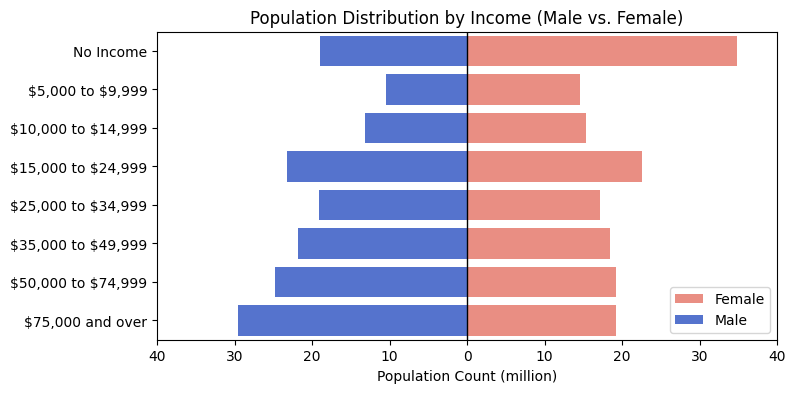

In [8]:
gpc_butterfly = gpc_male.merge(
    gpc_fmle, on="Personal Income", suffixes=("_Male", "_Female")
)
gpc_butterfly["Population Count_Male"] *= -1
plt.figure(figsize=(8, 4))
labels = gpc_butterfly["Personal Income"].astype(str)

sns.barplot(
    data=gpc_butterfly,
    y=labels,
    x="Population Count_Female",
    color="salmon",
    label="Female",
    errorbar=None,
)

sns.barplot(
    data=gpc_butterfly,
    y=labels,
    x="Population Count_Male",
    color="royalblue",
    label="Male",
    errorbar=None,
)

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Population Count (million)")
plt.ylabel("")
plt.title("Population Distribution by Income (Male vs. Female)")
plt.legend(loc="lower right")
plt.xticks(
    np.linspace(-40_000_000, 40_000_000, 9),
    labels=[int(x) for x in np.abs(np.linspace(-40, 40, 9))],
)

plt.show()

### Gender/Education/Population

In [9]:
gec_df = (
    df[
        (df["Age"] != "00 to 17")
        & (df["Age"] != "65 to 80+")
        & (df["Educational Attainment"] != "Children under 15")
    ]
    .drop(columns=["Year", "Age", "Personal Income", "Race"])
    .groupby(["Gender", "Educational Attainment"])
    .sum()
    .reset_index()
    .copy()
)
gec_df.head()

,Gender,Educational Attainment,Population Count
0,Female,Bachelor's degree or higher,50464659
1,Female,High school or equivalent,33014061
2,Female,No high school diploma,24170674
3,Female,"Some college, less than 4-yr degree",53608172
4,Male,Bachelor's degree or higher,41153429


In [10]:
gec_df = reorder_column(gec_df, "Educational Attainment", edu_order)
gec_df.head()

,Gender,Educational Attainment,Population Count
0,Female,No high school diploma,24170674
1,Male,No high school diploma,29334045
2,Female,High school or equivalent,33014061
3,Male,High school or equivalent,39960088
4,Female,"Some college, less than 4-yr degree",53608172


In [11]:
gec_male = (
    gec_df[gec_df["Gender"] == "Male"]
    .drop(columns=["Gender"])
    .reset_index(drop=True)
    .copy()
)
gec_fmle = (
    gec_df[gec_df["Gender"] == "Female"]
    .drop(columns=["Gender"])
    .reset_index(drop=True)
    .copy()
)

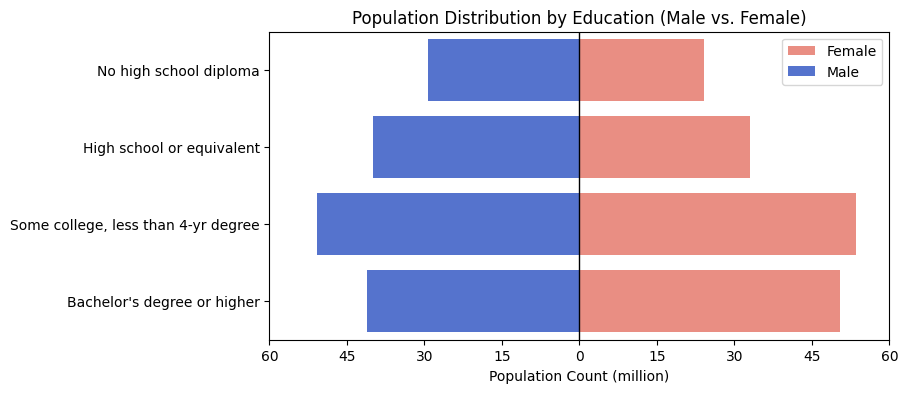

In [12]:
gec_butterfly = gec_male.merge(
    gec_fmle, on="Educational Attainment", suffixes=("_Male", "_Female")
)
gec_butterfly["Population Count_Male"] *= -1
plt.figure(figsize=(8, 4))
labels = gec_butterfly["Educational Attainment"].astype(str)

sns.barplot(
    data=gec_butterfly,
    y=labels,
    x="Population Count_Female",
    color="salmon",
    label="Female",
    errorbar=None,
)

sns.barplot(
    data=gec_butterfly,
    y=labels,
    x="Population Count_Male",
    color="royalblue",
    label="Male",
    errorbar=None,
)

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Population Count (million)")
plt.ylabel("")
plt.title("Population Distribution by Education (Male vs. Female)")
plt.legend(loc="upper right")
plt.xticks(
    np.linspace(-60_000_000, 60_000_000, 9),
    labels=[int(x) for x in np.abs(np.linspace(-60, 60, 9))],
)

plt.show()

### Race/Population

In [13]:
rp_df = (
    df[
        (df["Age"] != "00 to 17")
        & (df["Age"] != "65 to 80+")
        & (df["Educational Attainment"] != "Children under 15")
    ]
    .drop(columns=["Year", "Age", "Personal Income", "Gender", "Educational Attainment"])
    .groupby(["Race"])
    .sum()
    .reset_index()
    .copy()
)
rp_df = rp_df.sort_values(by="Population Count", ascending=True)
rp_df.head()

,Race,Population Count
2,Native American,2252319
0,African American,19476587
1,Asian,47419124
3,Other,74204188
4,White,179081950


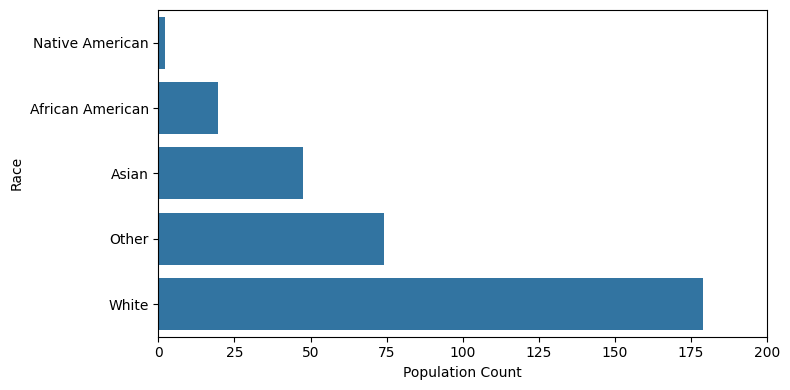

In [14]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=rp_df,
    y="Race",
    x="Population Count",
)
plt.xticks(
    np.linspace(0, 200_000_000, 9),
    labels=[int(x) for x in np.abs(np.linspace(0, 200, 9))],
)
plt.tight_layout()
plt.show()

### Race/Income/Population

In [15]:
rip_df = (
    df[
        (df["Age"] != "00 to 17")
        & (df["Age"] != "65 to 80+")
        & (df["Educational Attainment"] != "Children under 15")
    ]
    .drop(columns=["Year", "Age", "Gender", "Educational Attainment"])
    .groupby(["Race", "Personal Income"])
    .sum()
    .reset_index()
    .copy()
)
rip_df.head()

,Race,Personal Income,Population Count
0,African American,No Income,3314180
1,African American,"\$10,000 to \$14,999",2162944
2,African American,"\$15,000 to \$24,999",2566850
3,African American,"\$25,000 to \$34,999",2102874
4,African American,"\$35,000 to \$49,999",2475816


In [16]:
rip_df = reorder_column(rip_df, "Personal Income", income_order)

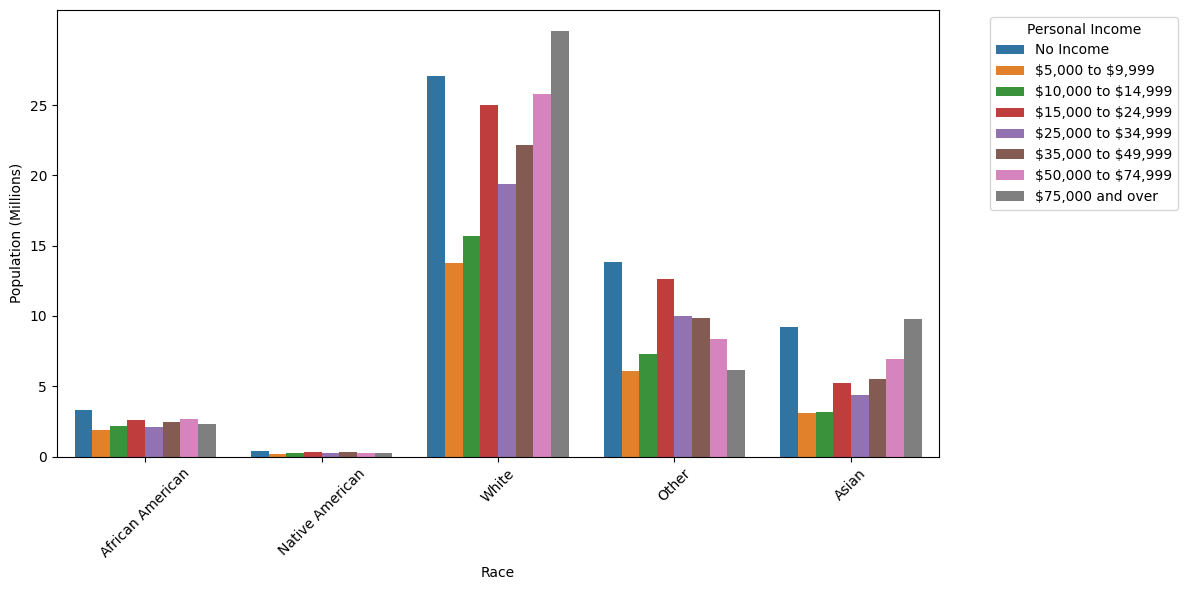

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=rip_df,
    x="Race",
    y="Population Count",
    hue="Personal Income",
    hue_order=income_order,
)

plt.xticks(rotation=45)
plt.ylabel("Population (Millions)")
plt.yticks(
    np.linspace(0, 25_000_000, 6),
    labels=[int(x) for x in np.linspace(0, 25, 6)]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Personal Income")
plt.tight_layout()
plt.show()

### Income/Year

In [18]:
iy_df = (
    df[
        (df["Age"] != "00 to 17")
        & (df["Age"] != "65 to 80+")
        & (df["Educational Attainment"] != "Children under 15")
    ]
    .drop(columns=["Gender", "Age", "Educational Attainment", "Race"])
    .groupby(["Year", "Personal Income"])
    .sum()
    .reset_index()
    .copy()
)
iy_df.head()

,Year,Personal Income,Population Count
0,2008,No Income,3015876
1,2008,"\$10,000 to \$14,999",2022443
2,2008,"\$15,000 to \$24,999",3219749
3,2008,"\$25,000 to \$34,999",2433391
4,2008,"\$35,000 to \$49,999",2782413


In [19]:
iy_df = reorder_column(iy_df, "Personal Income", income_order)
iy_df = iy_df.sort_values(["Year", "Personal Income"])
iy_df.head()

,Year,Personal Income,Population Count
0,2008,No Income,3015876
18,2008,"\$5,000 to \$9,999",1756918
38,2008,"\$10,000 to \$14,999",2022443
45,2008,"\$15,000 to \$24,999",3219749
70,2008,"\$25,000 to \$34,999",2433391


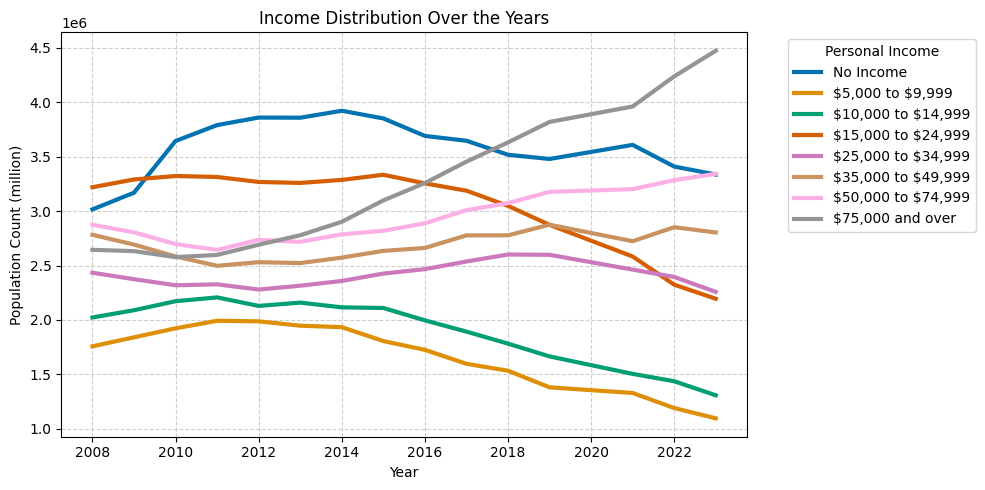

In [20]:
plt.figure(figsize=(10, 5))

sns.lineplot(
    data=iy_df,
    x="Year",
    y="Population Count",
    hue="Personal Income",
    hue_order=income_order,
    palette="colorblind",
    linewidth=3,
    markersize=10,
)

plt.xlabel("Year")
plt.ylabel("Population Count (million)")
plt.title("Income Distribution Over the Years")
plt.legend(
    title="Personal Income",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()